In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 4)
       
import hifiscan as hifi
audio = hifi.Audio()

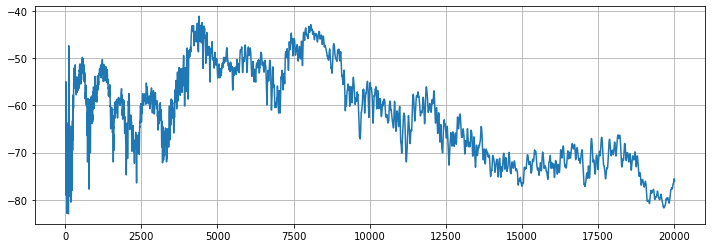

In [2]:
# Spectrum measurement
analyzer = hifi.Analyzer(f0=20, f1=20000, secs=1, rate=audio.rate, ampl=0.4)
audio.play(analyzer.chirp)
async for recording in audio.record():
    if analyzer.findMatch(recording):
        break
    if analyzer.timedOut():
        raise Exception('Timeout')
        
spectrum = analyzer.spectrum(smoothing=10)
plt.plot(*spectrum)
plt.grid()

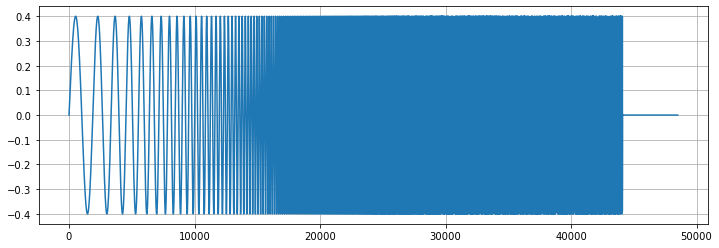

In [3]:
# Input stimulus x
plt.plot(analyzer.x)
plt.grid()

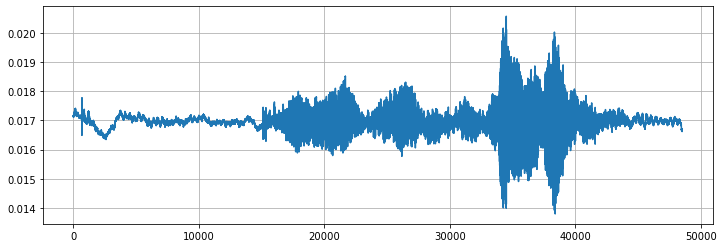

In [4]:
# Output response y
plt.plot(analyzer.y)
plt.grid()

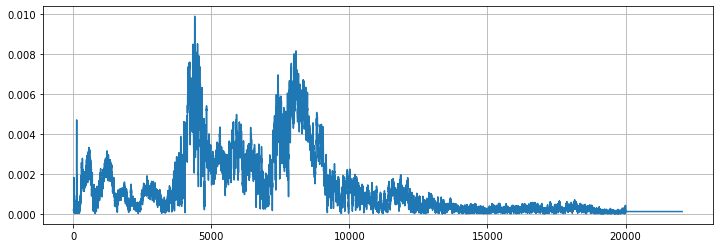

In [16]:
# Transfer function H = X / Y, with X = FT(x), Y = FT(y) and FT the Fourier Transform
# f, H = analyzer.H()
f, H2 = analyzer.H2(smoothing=0)
H = H2 ** 0.5
plt.plot(f, H)
plt.grid()

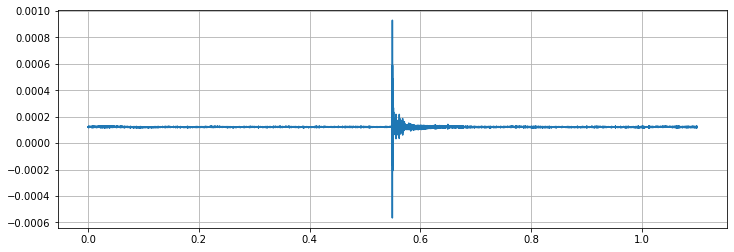

In [6]:
# Impulse response h = IFT(H), with IFT the Inverse Fourier Transform
t, h = analyzer.h()
plt.plot(t, h)
plt.grid()
audio.play(h / np.abs(h).max())

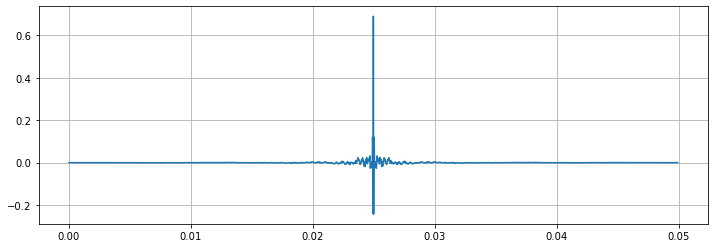

In [7]:
# Inverse impulse response h_inv = IFT(1 / H)
t, h_inv = analyzer.h_inv(
    secs=0.05,
    dbRange=24,
    kaiserBeta=5,
    smoothing=15)
plt.plot(t, h_inv)
plt.grid()
# audio.play(h_inv / np.abs(h_inv).max())
# hifi.write_wav('IR.wav', audio.rate, h_inv)

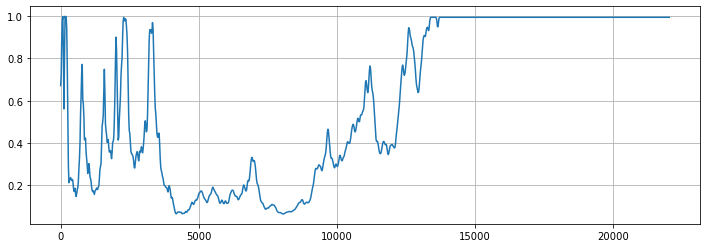

In [8]:
# Correction factor that h_inv applies for every frequency
corrFactor = analyzer.correctionFactor(h_inv)
plt.plot(*corrFactor)
plt.grid()

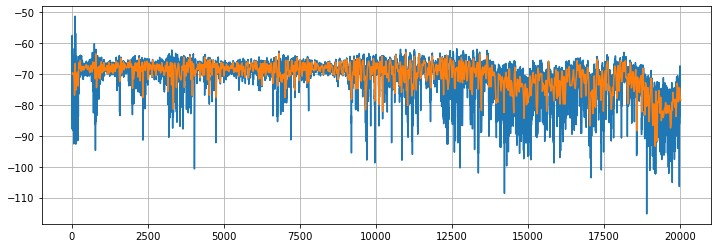

In [9]:
# Expected corrected spectrum
sp1, sp2 = analyzer.correctedSpectrum(corrFactor)
plt.plot(*sp1)
plt.plot(*sp2)
plt.grid()

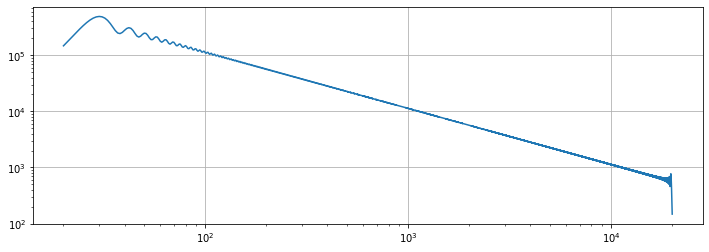

In [10]:
# Power distribution of the chirp
x = analyzer.chirp
y = np.abs(np.fft.rfft(x)) ** 2
f = np.linspace(0, analyzer.rate / 2, y.size)
r = analyzer.freqRange(f.size)
plt.loglog(f[r], y[r])
plt.grid()

In [12]:
# Play some tones
tones = [0.4 * hifi.tone(440 * i, 0.1, audio.rate) for i in range(1, 12)]
for tone in tones:
    audio.play(tone)

In [13]:
# Create a missing fundamental of 20 Hz
# https://en.wikipedia.org/wiki/Missing_fundamental
tones = [hifi.tone(20 * i, 2, audio.rate) / i for i in range(6, 22)]
for chord in np.cumsum(tones[::-1], 0):
    chord /= np.abs(chord).max()
    audio.play(chord)

In [22]:
audio.close()